In [1]:
import os
import ast
import cv2
import json
import math
import shutil
import random
import pickle
import imageio
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
from pprint import pprint
from datetime import datetime, timedelta, date
# from geopy.geocoders import Nominatim
# from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
from utils import normalize_image, get_sequences, plot_image, plot_images
from dust_analysis import left_pass_pairs, right_pass_pairs, read_raw_image, read_rectified_image, print_seg_performance, print_seg_dust_performance, get_seg_dust_performance_by_time

## Analyze the vehicle in dust datasets (two datasets: labeled and full unlabeled)

In [27]:
data_root_dir = '/data2/jupiter/datasets'
unlabeled_datasets = ["halo_vehicles_driving_through_dust_images_nodust_reserved_stereo"]
labeled_datasets = ["halo_vehicles_driving_through_dust_images_nodust_reserved_labeled"]
pred_root_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/'
models = [
    # '20676_r2_rgb_bigdecay_biglr',
    'v81_nextvitsmall_dust_only_kore_dean_0406',
    'v81_80k_maxfov_iwtv_kore_0423_v81_dust_0430'
    # 'v81_80k_maxfov_wn_ft_kore_0430_v81_dust_0501',
]

In [28]:
di = 0
suffix = '_maxfov_alleysson_depth0423'
# raw_df = pd.read_csv(os.path.join(data_root_dir, unlabeled_datasets[di], 'master_annotations_mhc.csv'))
# raw_df = pd.read_csv(os.path.join(data_root_dir, unlabeled_datasets[di], 'master_annotations.csv'))
raw_df = pd.read_csv(os.path.join(data_root_dir, unlabeled_datasets[di]+suffix, 'master_annotations.csv'))
raw_df['camera_pair'] = raw_df.unique_id.apply(lambda s: s[-7:])
# stereo_df = pd.read_csv(os.path.join(data_root_dir, labeled_datasets[di], 'master_annotations.csv'))
stereo_df = pd.read_csv(os.path.join(data_root_dir, labeled_datasets[di]+suffix, 'master_annotations.csv'))
stereo_df['camera_pair'] = stereo_df.unique_id.apply(lambda s: s[-7:])
print(raw_df.shape, stereo_df.shape)

(11139, 138) (4764, 252)


In [29]:
def read_csvs(pred_root_dir, model, labeled_dataset):
    pred_df = pd.read_csv(os.path.join(pred_root_dir, model, labeled_dataset, 'output.csv'))
    if not 'state' in pred_df:
        pred_df['state'] = pred_df['result_state']
    dust_df = pd.read_csv(os.path.join(pred_root_dir, model, labeled_dataset, 'dust_ratio.csv'))
    print(pred_df.shape, dust_df.shape)
    return pred_df, dust_df

In [30]:
# load pred and dust df
pred_df1, dust_df1 = read_csvs(pred_root_dir, models[0], labeled_datasets[di])
pred_df2, dust_df2 = read_csvs(pred_root_dir, models[1], labeled_datasets[di]+suffix)
# compare performance
print_seg_dust_performance(pred_df1, dust_df1, model_desc='lite12')
print_seg_dust_performance(pred_df2, dust_df2, model_desc='nextvit')

(4764, 16) (4764, 7)
(4764, 16) (4764, 7)
lite12: TP 2409, TN 1908, FP 3, FN 444, Recall 0.8444, Productivity 0.9984
lite12 dust: TP 0.16, TN 0.15, FP 0.11, FN 0.27
nextvit: TP 2464, TN 1795, FP 8, FN 497, Recall 0.8322, Productivity 0.9956
nextvit dust: TP 0.18, TN 0.13, FP 0.11, FN 0.25


In [31]:
# get performance by operation time
get_seg_dust_performance_by_time(raw_df, pred_df1, dust_df1, model_desc='lite12')
get_seg_dust_performance_by_time(raw_df, pred_df2, dust_df2, model_desc='nextvit')

(1932, 152) (2832, 152)
lite12 day: TP 899, TN 935, FP 3, FN 95, Recall 0.9044, Productivity 0.9968
lite12 day dust: TP 0.17, TN 0.10, FP 0.11, FN 0.27
lite12 night: TP 1510, TN 973, FP 0, FN 349, Recall 0.8123, Productivity 1.0000
lite12 night dust: TP 0.15, TN 0.19, FP nan, FN 0.27
(1932, 152) (2832, 152)
nextvit day: TP 926, TN 909, FP 3, FN 94, Recall 0.9078, Productivity 0.9967
nextvit day dust: TP 0.13, TN 0.06, FP 0.04, FN 0.19
nextvit night: TP 1538, TN 886, FP 5, FN 403, Recall 0.7924, Productivity 0.9944
nextvit night dust: TP 0.20, TN 0.21, FP 0.15, FN 0.26


In [32]:
dust_df2.head(2)

,unique_id,id,gt_dust_ratio,total_averaged_dust_conf,total_thresholded_dust_ratio,masked_avg_dust_conf,masked_dust_ratio
0,65e98b4a6af3b51a246857d2_T06_T07,65e98b4a6af3b51a246857d2,0.0,0.043508,0.012939,0.019465,0.0
1,65e98bb8e4305312190a9021_T06_T07,65e98bb8e4305312190a9021,0.0,0.046771,0.016602,0.028646,0.0


In [19]:
seq_dfs = get_sequences(stereo_df, interval=60, per_camera=False)
print(len(seq_dfs))

27


In [67]:
def get_text(raw_row, pred_df, dust_df, model_desc):
    s = ''
    c = (255,0,0)
    pred_rows = pred_df[pred_df.unique_id == raw_row.unique_id]
    if len(pred_rows) > 0:
        state = pred_rows.iloc[0].state
        if state == 'true_positive' or state == 'true_negative':
            c = (0,255,0)
        s += f'{model_desc} state: {state}'
    dust_rows = dust_df[dust_df.unique_id == raw_row.unique_id]
    if len(dust_rows) > 0:
        s += f' dust: {dust_rows.iloc[0].total_averaged_dust_conf*100:.2f}%'
    return s, c

def add_text2(frame, raw_row, pred_df1, dust_df1, pred_df2, dust_df2, model_desc1, model_desc2):
    frame = cv2.putText(frame, f'{raw_row.camera_pair}, {raw_row.collected_on}', 
                        (10,25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
    s1, c1 = get_text(raw_row, pred_df1, dust_df1, model_desc1)
    if s1:
        frame = cv2.putText(frame, s1, 
                            (10,65), cv2.FONT_HERSHEY_SIMPLEX, 1, c1, 2, cv2.LINE_AA)
    s2, c2 = get_text(raw_row, pred_df2, dust_df2, model_desc2)
    if s2:
        frame = cv2.putText(frame, s2, 
                            (10,105), cv2.FONT_HERSHEY_SIMPLEX, 1, c2, 2, cv2.LINE_AA)
    return frame

In [68]:
def create_video_from_rectified_rgb2(seq_dfs, si, raw_df, pred_root_dir, model, labeled_datasets, di, data_root_dir, unlabeled_datasets, 
                                    pred_df1, dust_df1, pred_df2, dust_df2, model_desc1, model_desc2):
    seq_df = seq_dfs[si]

    # get raw sequence
    start, end = seq_df.iloc[0].collected_on, seq_df.iloc[-1].collected_on
    seq_raw_df = raw_df[(raw_df.collected_on >= start) & (raw_df.collected_on <= end)]
    print(f'process {si}th sequence', seq_df.shape, seq_raw_df.shape)

    # compare model performance
    sub_pred_df1 = pred_df1[pred_df1.unique_id.isin(seq_df.unique_id)]
    sub_pred_df2 = pred_df2[pred_df2.unique_id.isin(seq_df.unique_id)]
    print_seg_performance(sub_pred_df1, model_desc1)
    print_seg_performance(sub_pred_df2, model_desc2)

    # get pair-wise cameras
    cameras = list(seq_df.camera_location.unique())
    cameras.sort()
    camera_pairs = list(seq_df.camera_pair.unique())
    camera_pairs.sort()
    # print(cameras, camera_pairs)

    # check if should use left pass or right pass or both
    in_left = set(camera_pairs).intersection(left_pass_pairs)
    in_right = set(camera_pairs).intersection(right_pass_pairs)
    # print(len(in_left), len(in_right))
    if len(in_left) > len(in_right):
        camera_pairs = left_pass_pairs
        pass_key = 'left_pass'
    elif len(in_left) < len(in_right):
        camera_pairs = right_pass_pairs
        pass_key = 'right_pass'
    else:
        pass_key = 'short_pass'

    # get per-camera dfs and truncate to same length
    camera_dfs = [seq_raw_df[seq_raw_df.unique_id.str.endswith(c)] for c in camera_pairs]
    camera_dfs = [cdf.sort_values('collected_on', ignore_index=True) for cdf in camera_dfs]
    min_len = min(len(cdf) for cdf in camera_dfs)
    camera_dfs = [cdf.iloc[:min_len] for cdf in camera_dfs]
    # print([len(cdf) for cdf in camera_dfs])

    # create video
    video_dir = os.path.join(pred_root_dir, model, labeled_datasets[di], 'videos_compare_newcolor')
    os.makedirs(video_dir, exist_ok=True)
    video_name = os.path.join(video_dir, f'{start}_{pass_key}_{si}.mp4')
    height, width = 512, 768
    # print(width*2,height*math.ceil(len(camera_dfs)/2))

    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 3, (width*2,height*math.ceil(len(camera_dfs)/2)), isColor=True)
    for fi in range(min_len):
        frames = []
        for pair_i in range(math.ceil(len(camera_dfs)/2)):
            pair_frame = []
            for _fi in range(2):
                if pair_i*2+_fi == len(camera_dfs):
                    frame = np.zeros((512, 768, 3), dtype=np.uint8)
                else:
                    frame = read_rectified_image(data_root_dir, unlabeled_datasets[di], camera_dfs[pair_i*2+_fi].iloc[fi])
                    if frame.shape[1] == 640:
                        zeros = np.zeros((512, 768, 3), dtype=frame.dtype)
                        zeros[:,:640,:] = frame
                        frame = zeros
                    frame = add_text2(frame, camera_dfs[pair_i*2+_fi].iloc[fi], pred_df1, dust_df1, pred_df2, dust_df2, model_desc1, model_desc2)
                pair_frame.append(frame)
            pair_frame = np.concatenate(pair_frame, axis=1)
            frames.append(pair_frame)
        frame = np.concatenate(frames, axis=0)
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video.write(frame)
    # cv2.destroyAllWindows()
    video.release()

for si in range(len(seq_dfs)):
    # si = 6
    # create_video_from_rectified_rgb(seq_dfs, si, raw_df, pred_root_dir, model, labeled_datasets, di, data_root_dir, unlabeled_datasets, pred_df, dust_df)
    create_video_from_rectified_rgb2(seq_dfs, si, raw_df, pred_root_dir, models[1], labeled_datasets, di, data_root_dir, unlabeled_datasets, 
                                    pred_df1, dust_df1, pred_df2, dust_df2, model_desc1='lite12', model_desc2='nextvit')
    # break

process 0th sequence (154, 239) (232, 137)
lite12: TP 71, TN 75, FP 5, FN 3
nextvit: TP 73, TN 80, FP 0, FN 1
process 1th sequence (158, 239) (223, 137)
lite12: TP 68, TN 81, FP 2, FN 7
nextvit: TP 74, TN 84, FP 0, FN 0
process 2th sequence (150, 239) (262, 137)
lite12: TP 86, TN 57, FP 2, FN 5
nextvit: TP 90, TN 59, FP 1, FN 0
process 3th sequence (157, 239) (282, 137)
lite12: TP 83, TN 63, FP 3, FN 8
nextvit: TP 88, TN 66, FP 1, FN 2
process 4th sequence (93, 239) (177, 137)
lite12: TP 33, TN 45, FP 13, FN 2
nextvit: TP 33, TN 58, FP 0, FN 2
process 5th sequence (89, 239) (138, 137)
lite12: TP 14, TN 57, FP 9, FN 9
nextvit: TP 7, TN 67, FP 0, FN 15
process 6th sequence (127, 239) (181, 137)
lite12: TP 37, TN 71, FP 10, FN 9
nextvit: TP 26, TN 81, FP 0, FN 20
process 7th sequence (85, 239) (169, 137)
lite12: TP 37, TN 34, FP 12, FN 2
nextvit: TP 26, TN 46, FP 0, FN 13
process 8th sequence (226, 239) (332, 137)
lite12: TP 68, TN 116, FP 23, FN 19
nextvit: TP 64, TN 140, FP 0, FN 22
pro

## Check performance on standalone dataset

In [39]:
# root_dir = '/data/jupiter/li.yu/data'
root_dir = '/data/jupiter/datasets/'
# root_dir = '/data2/jupiter/datasets/'
# root_dir = '/data2/jupiter/datasets/rev1_ask_ben_cline_before_deleting'
dataset = 'halo_failure_case_of_box_in_dust'
# dataset = 'humans_on_path_test_set_2023_v15_anno'
# dataset = 'halo_vehicles_driving_through_dust_images_nodust_reserved_labeled'
# csv = os.path.join(root_dir, dataset, 'master_annotations_mhc.csv')
csv = os.path.join(root_dir, dataset, 'master_annotations.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
df = pd.read_csv(csv, converters=converters)
df.shape

/home/li.yu/anaconda3/envs/pytorchlightning/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (2,105) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(55795, 150)

In [3]:
def read_csvs(pred_root_dir, model, labeled_dataset):
    pred_df = pd.read_csv(os.path.join(pred_root_dir, model, labeled_dataset, 'output.csv'))
    if not 'state' in pred_df:
        pred_df['state'] = pred_df['result_state']
    dust_df = pd.read_csv(os.path.join(pred_root_dir, model, labeled_dataset, 'dust_ratio.csv'))
    print(pred_df.shape, dust_df.shape)
    return pred_df, dust_df

In [44]:
pred_root_dir = '/data/jupiter/li.yu/exps/driveable_terrain_model/'
# model = 'v511rd_7cls_ft_dustaugonhuman_0908_v481_dusthead_0917'
# model = '20676_r2_rgb_bigdecay_biglr'
model = 'v81_80k_maxfov_iwtv_kore_0423_v81_dust_0430'
# model = 'v81_80k_maxfov_wn_ft_kore_0430_v81_dust_0501'

# load pred and dust df
pred_df, dust_df = read_csvs(pred_root_dir, model, dataset)

(55793, 16) (55793, 7)


In [5]:
pred_df.head(2)

,unique_id,id,camera_location,operation_time,special_notes,jdb_s3_path,result_state,result_human_state,result_vehicle_state,min_pixels_threshold,features,n_gt_human_pixels,gt_human_depth,n_pred_human_pixels,pred_human_depth,state
0,66312df2a9217d4c75fcb245_T02_T03,66312df2a9217d4c75fcb245,T02,daytime,NaN,NaN,false_positive,NaN,true_negative,67,"{""large_object_pixels"": 752, ""large_object_min...",0,1000,0,1000,false_positive
1,66312e3c22aa441a4b2ff40e_T02_T03,66312e3c22aa441a4b2ff40e,T02,daytime,NaN,NaN,true_negative,NaN,true_negative,67,"{""large_object_pixels"": 96, ""large_object_min_...",0,1000,0,1000,true_negative


In [6]:
dust_df.head(2)

,unique_id,id,gt_dust_ratio,total_averaged_dust_conf,total_thresholded_dust_ratio,masked_avg_dust_conf,masked_dust_ratio
0,66312df2a9217d4c75fcb245_T02_T03,66312df2a9217d4c75fcb245,0.0,0.000005,0.0,4.520174e-05,0.0
1,66312e3c22aa441a4b2ff40e_T02_T03,66312e3c22aa441a4b2ff40e,0.0,0.000021,0.0,2.726665e-08,0.0


In [45]:
dust_df[dust_df.total_averaged_dust_conf > 0.1].shape

(0, 7)

In [46]:
dust_df.total_averaged_dust_conf.describe()

count    5.579300e+04
mean     7.271954e-06
std      3.095858e-05
min      2.970001e-09
25%      1.973559e-07
50%      7.167830e-07
75%      4.079536e-06
max      1.389745e-03
Name: total_averaged_dust_conf, dtype: float64

## Display images

In [33]:
# root_dir = '/data/jupiter/li.yu/data'
# root_dir = '/data/jupiter/datasets/'
root_dir = '/data2/jupiter/datasets/'
dataset = 'halo_vehicles_driving_through_dust_images_nodust_reserved_stereo'
# dataset = 'halo_vehicles_driving_through_dust_images_nodust_reserved_labeled'
# csv = os.path.join(root_dir, dataset, 'master_annotations_mhc.csv')
csv = os.path.join(root_dir, dataset, 'master_annotations.csv')
converters = {"label_map": ast.literal_eval, "label_counts": ast.literal_eval}
# converters = {}
df = pd.read_csv(csv, converters=converters)
df.shape

(9630, 136)

In [37]:
df2 = df.merge(dust_df1, on='unique_id')
print(df2.shape)
df3 = df2[df2.total_averaged_dust_conf > 0.2]
print(df3.shape)

(4313, 142)
(1263, 142)


In [52]:
df2 = df.merge(pred_df, on='unique_id')
# df2 = df.merge(dust_df, on='unique_id')
print(df2.shape)
df3 = df2[df2.collected_on.str.startswith('2024-04-23T15:24:15')]
print(df3.shape)

(55795, 165)
(6, 165)


In [55]:
df3['vehicle_pixel'] = df3['features'].apply(lambda d: ast.literal_eval(d).get('vehicle_pixels'))
df3['large_object_pixels'] = df3['features'].apply(lambda d: ast.literal_eval(d).get('large_object_pixelss'))
df3[['unique_id', 'n_pred_human_pixels', 'vehicle_pixel', 'large_object_pixels']]

<ipython-input-55-46c7375890e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['vehicle_pixel'] = df3['features'].apply(lambda d: ast.literal_eval(d).get('vehicle_pixels'))
<ipython-input-55-46c7375890e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['large_object_pixels'] = df3['features'].apply(lambda d: ast.literal_eval(d).get('large_object_pixelss'))


,unique_id,n_pred_human_pixels,vehicle_pixel,large_object_pixels
648,663137a482d005a612b5bca2_T01_T03,0,304,None
703,6631380c77a975168cd1821a_T01_T03,0,288,None
2987,663137a2eb919104bd9022b3_T02_T04,0,0,None
3041,6631380a71621c9f9f0f6676_T02_T04,0,0,None
5325,663137a2eb919104bd9022b3_T02_T03,0,0,None
5379,6631380a71621c9f9f0f6676_T02_T03,0,0,None


663137a482d005a612b5bca2_T01_T03 0.0 7.944954e-07 0.0


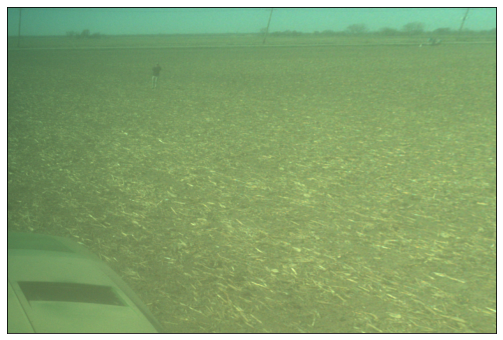

/data/jupiter/li.yu/exps/driveable_terrain_model/v81_80k_maxfov_iwtv_kore_0423_v81_dust_0430/halo_failure_case_of_box_in_dust/output_visualization/663137a482d005a612b5bca2_T01_T03.png


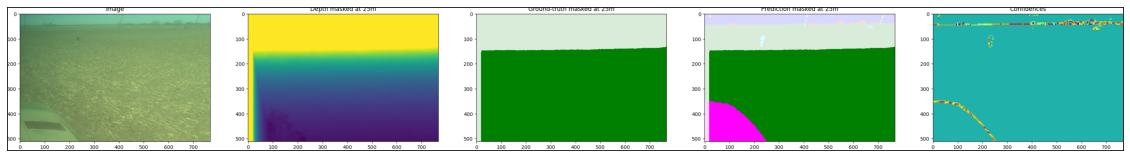

6631380a71621c9f9f0f6676_T02_T04 0.0 4.63278e-06 0.0


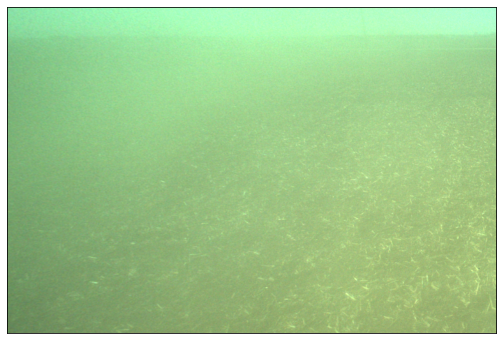

/data/jupiter/li.yu/exps/driveable_terrain_model/v81_80k_maxfov_iwtv_kore_0423_v81_dust_0430/halo_failure_case_of_box_in_dust/output_visualization/6631380a71621c9f9f0f6676_T02_T04.png


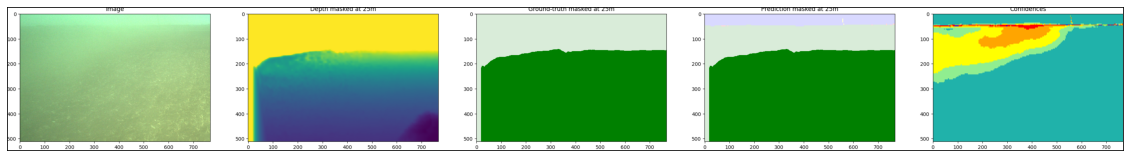

In [51]:
# sub_df = df[df.id.isin(cat_df.id)].sample(2)
# sub_df = df[df.bag_date == '12_04_2023'].sample(2)
# sub_df = df[df.unique_id.isin(['65e9b50a06198505e2a58145_T14_T15', '65e9beba4875033da619fb9b_T05_T07'])]
# sub_df = df[df.id.isin(['6441f343fb7e8d35a3da7e9c', '6441f9199b12538afbfcc044'])]
sub_df = df3.sample(2)
show_image, show_label = True, False
show_debayered_rgb, show_raw_label = False, False
show_pred_result = True

for i, row in sub_df.iterrows():
    print(row.unique_id, row.gt_dust_ratio, row.total_averaged_dust_conf, row.total_thresholded_dust_ratio)
    # print(row.unique_id, row.camera_location, row.collected_on, row.operation_time)
    if show_image:
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        # print(data_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, True)
        plot_image(img_norm)

    if show_debayered_rgb:
        # print(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        image = imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
        label = np.load(label_path)['left']
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        # print(row.id, np.unique(label))
        plot_image(label == 25)

    if show_raw_label:
        label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        plot_image(label == 25)

    if show_pred_result:
        result_path = os.path.join(pred_root_dir, model, dataset, 'output_visualization', row.unique_id+'.png')
        print(result_path)
        if os.path.isfile(result_path):
            res_img = cv2.cvtColor(cv2.imread(result_path), cv2.COLOR_BGR2RGB)
            plot_image(res_img, figsize=(20, 6))

65e9b7c76af3b51a2468b610_T09_T11 0.0 0.23443063 0.22216796875


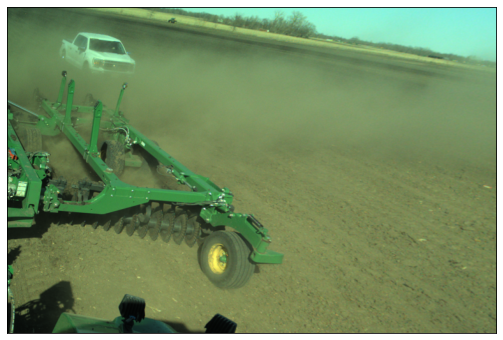

65e9a5b1bc620c2c14fe00cb_T10_T12 0.0 0.35229293 0.3177083333333333


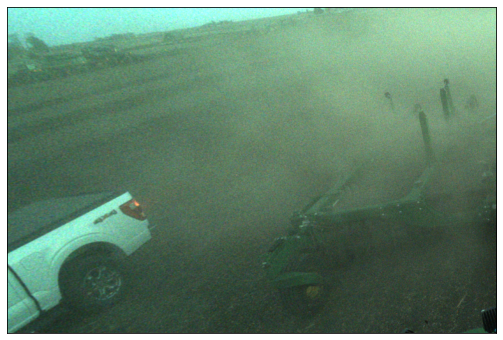

In [38]:
# sub_df = df[df.id.isin(cat_df.id)].sample(2)
# sub_df = df[df.bag_date == '12_04_2023'].sample(2)
# sub_df = df[df.unique_id.isin(['65e9b50a06198505e2a58145_T14_T15', '65e9beba4875033da619fb9b_T05_T07'])]
# sub_df = df[df.id.isin(['6441f343fb7e8d35a3da7e9c', '6441f9199b12538afbfcc044'])]
sub_df = df3.sample(2)
show_image, show_label = True, False
show_debayered_rgb, show_raw_label = False, False
show_pred_result = False

for i, row in sub_df.iterrows():
    print(row.unique_id, row.gt_dust_ratio, row.total_averaged_dust_conf, row.total_thresholded_dust_ratio)
    # print(row.unique_id, row.camera_location, row.collected_on, row.operation_time)
    if show_image:
        data_path = os.path.join(root_dir, dataset, row.stereo_pipeline_npz_save_path)
        # print(data_path)
        img = np.load(data_path)['left']
        img_norm = normalize_image(img, True)
        plot_image(img_norm)

    if show_debayered_rgb:
        # print(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        image = imageio.imread(os.path.join(root_dir, dataset, row.artifact_debayeredrgb_0_save_path))
        plot_image(image)

    if show_label and 'rectified_label_save_path' in row and isinstance(row.rectified_label_save_path, str):
        label_path = os.path.join(root_dir, dataset, row.rectified_label_save_path)
        label = np.load(label_path)['left']
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        # print(row.id, np.unique(label))
        plot_image(label == 25)

    if show_raw_label:
        label = imageio.imread(os.path.join(root_dir, dataset, row.annotation_pixelwise_0_save_path))
        labels = np.unique(label)
        label_map =row.label_map
        label_strs = [label_map[str(i)] for i in labels if i != 0]
        print(row.unique_id, labels, label_strs)
        plot_image(label == 25)

    if show_pred_result:
        result_path = os.path.join(pred_root_dir, model, dataset, 'output_visualization', row.unique_id+'.png')
        print(result_path)
        if os.path.isfile(result_path):
            res_img = cv2.cvtColor(cv2.imread(result_path), cv2.COLOR_BGR2RGB)
            plot_image(res_img, figsize=(20, 6))

### plot gt dust vs. pre dust

In [ ]:
df2 = df.sort_values(by='gt_dust_ratio')
gt_ratios = df2.gt_dust_ratio.to_list()
pred_ratios = df2.total_thresholded_dust_ratio.to_list()

plt.figure(1, figsize=(12, 6))
plt.plot(range(len(gt_ratios)), gt_ratios, c='b', marker=".", label='gt dust level')
plt.scatter(range(len(gt_ratios)), pred_ratios, s=15, c='r', marker="o", label='pred dust level')
plot_human_state = False
if plot_human_state:
    tp_ids, fn_ids = [], []
    for i,row in df.iterrows():
        if row.state_y == 'true_positive':
            tp_ids.append(i)
        if row.state_y == 'false_negative':
            fn_ids.append(i)
    plt.scatter(tp_ids, [0.4] * len(tp_ids), s=20, c='g', marker="o", label='pred human TP')
    plt.scatter(fn_ids, [0.6] * len(fn_ids), s=20, c='purple', marker="o", label='pred human FN')
plt.legend(loc='upper left')
plt.ylim([-0.02, 1.0])
plt.xlabel('images in ascending gt dust level order')
plt.ylabel('dust level')
plt.show()